In [8]:
import cv2
import csv
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
# Define the path to the directory containing images
path = r'C:\Users\mathe\Ufal\PDI\Deffect-detection\lego'  # Adjust this to your actual image directory path

# Read train.csv file
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Extract the list of training image IDs
listTrain = train_df['example_id'].values.tolist()

print(f"Loaded {len(listTrain)} training images from train.csv")
print(f"Image directory: {path}")

Loaded 90 training images from train.csv
Image directory: C:\Users\mathe\Ufal\PDI\Deffect-detection\lego


## Desenvolvimento com Adaptive Threshold

Este notebook adapta o projeto original para usar **Adaptive Threshold** ao invés do detector de bordas Canny. O adaptive threshold é mais robusto para diferentes condições de iluminação e pode capturar melhor os detalhes das peças LEGO.

### Funções de Ajuste

In [ ]:
def getPictures():
    train, test = [], []
    for i in os.listdir(path):
        # Skip non-image files (like CSV files)
        if not i.lower().endswith(('.jpg')):
            continue
            
        # Image
        img = cv2.imread(os.path.join(path, i))
        
        # Check if image was loaded successfully
        if img is None:
            print(f"Warning: Could not load image {i}")
            continue
            
        # Adjusts height
        h = img.shape[0]
        img = img[int(0.095*h):int(0.905*h), :]
        # set the lists
        img_id = i.rsplit('.', 1)[0]
        if img_id in set(listTrain):
            train.append([img, img_id])
        else:
            test.append([img, img_id])
    return train, test

def getIndexLeft(img):
    h, w = img.shape
    index = -1
    for i in range(0, w//2):
        count = 0
        for j in range(h):
            if img[j, i] > 128:
                img[j, i] = 255
            count = count + img[j, i]
        if count == 255*h:
            index = i
    return index

def getIndexRight(img, id):
    h, w = img.shape
    index = -100000
    if id == 'yasvgpdjm':
        return w - 20
    for i in range(w-1, int(0.63*w), -1):
        count = 0
        for j in range(h):
            if img[j, i] > 128:
                img[j, i] = 255
            count = count + img[j, i]
        if count == 255*h:
            index = i
    if index >= 0:
        return index
    else:
        l = []
        for i in range(int(0.75*w), w):
            count = 0
            for j in range(h):
                count = count + img[j, i]
            l.append(count)
        return l.index(max(l)) + int(0.75*w)

def getStatusCenter(img):
    h, w = img.shape
    i = 0
    j = 0
    for k in range(h):
        i = i + img[k, int(((3*w)//7))]
        j = j + img[k, int(((5*w)//7))]
    if j == 255*h and i == 255*h:
        return True
    return False

def translateImg(img):
    first_row = img[0, :, :]
    non_white_mask = np.any(first_row != [255, 255, 255], axis=1)
    non_white_indices = np.where(non_white_mask)[0]
    l = list(non_white_indices)
    if not l:
        h, w = img.shape[:2]
        return img[:, int((w-h)/2):w-int((w-h)/2)]
    h, w = img.shape[:2]
    non_white_center = int((min(l) + max(l)) / 2)
    image_center = w // 2
    shift = image_center - non_white_center
    M = np.float32([[1, 0, shift], [0, 1, 0]])
    i = cv2.warpAffine(img, M, (w, h), borderValue=(255, 255, 255))
    return i[:, int((w-h)/2):w-int((w-h)/2)]

In [11]:
def adjustLego():
    train, test = getPictures()
    l1, l2 = [], []
    for i, id in train:
        img = cv2.cvtColor(i, cv2.COLOR_BGR2GRAY)
        h, w = img.shape
        L = getIndexLeft(img)
        R = getIndexRight(img, id)
        # Left index
        if L >= 0:
            i[:h, :L-15] = 255
            img[:h, :L-15] = 255
        # Right index
        if R >= 0:
            i[:h, R:] = 255
            img[:h, R:] = 255
        # Center Status
        if getStatusCenter(img):
            i[i>=0] = 255
        # Center img
        i = translateImg(i)
        l1.append([i, id])
    for i, id in test:
        img = cv2.cvtColor(i, cv2.COLOR_BGR2GRAY)
        h, w = img.shape
        L = getIndexLeft(img)
        R = getIndexRight(img, id)
        # Left index
        if L >= 0:
            i[:h, :L-15] = 255
            img[:h, :L-15] = 255
        # Right index
        if R >= 0:
            i[:h, R:] = 255
            img[:h, R:] = 255
        # Center Status
        if getStatusCenter(img):
            i[i>=0] = 255
        # Center img
        i = translateImg(i)
        l2.append([i, id])
    return l1, l2

In [12]:
def adaptive_threshold(l1, l2):
    """
    Função que aplica adaptive threshold ao invés de Canny edge detection.
    O adaptive threshold é mais robusto para diferentes condições de iluminação.
    """
    aux1, aux2 = l1.copy(), l2.copy()
    r1, r2 = [], []
    
    for i, id in aux1:
        img = cv2.cvtColor(i, cv2.COLOR_BGR2GRAY)
        height, width = img.shape
        
        # Aplicar ajuste de contraste e brilho
        imgScale = cv2.convertScaleAbs(img, alpha=1.2, beta=-50)
        
        # Aplicar filtro Gaussiano para reduzir ruído
        imgBlur = cv2.GaussianBlur(imgScale, (5, 5), 0)
        
        # Aplicar Adaptive Threshold
        # ADAPTIVE_THRESH_MEAN_C: threshold é a média dos valores vizinhos
        # ADAPTIVE_THRESH_GAUSSIAN_C: threshold é a soma ponderada gaussiana dos valores vizinhos
        adaptive_thresh = cv2.adaptiveThreshold(
            imgBlur, 
            255, 
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
            cv2.THRESH_BINARY, 
            blockSize=11,  # Tamanho da área vizinha usada para calcular o threshold
            C=2            # Constante subtraída da média
        )
        
        # Inverter a imagem para que as bordas fiquem brancas (similar ao Canny)
        adaptive_thresh = cv2.bitwise_not(adaptive_thresh)
        
        # Aplicar operações morfológicas para limpar a imagem
        kernel = np.ones((2, 2), np.uint8)
        adaptive_thresh = cv2.morphologyEx(adaptive_thresh, cv2.MORPH_CLOSE, kernel)
        adaptive_thresh = cv2.morphologyEx(adaptive_thresh, cv2.MORPH_OPEN, kernel)
        
        # Remover bordas externas (similar ao processo original)
        h, w = adaptive_thresh.shape
        for j in range(h):
            # Encontrar o primeiro índice não nulo
            first_nonzero = np.where(adaptive_thresh[j, :] > 0)[0]
            if first_nonzero.size > 0:
                first_idx = first_nonzero[0]
                adaptive_thresh[j, first_idx] = 0

            # Encontrar o último índice não nulo
            last_nonzero = np.where(adaptive_thresh[j, :] > 0)[0]
            if last_nonzero.size > 0:
                last_idx = last_nonzero[-1]
                adaptive_thresh[j, last_idx] = 0
        
        r1.append([adaptive_thresh, id])
    
    for i, id in aux2:
        img = cv2.cvtColor(i, cv2.COLOR_BGR2GRAY)
        height, width = img.shape
        
        # Aplicar ajuste de contraste e brilho
        imgScale = cv2.convertScaleAbs(img, alpha=1.2, beta=-50)
        
        # Aplicar filtro Gaussiano para reduzir ruído
        imgBlur = cv2.GaussianBlur(imgScale, (5, 5), 0)
        
        # Aplicar Adaptive Threshold
        adaptive_thresh = cv2.adaptiveThreshold(
            imgBlur, 
            255, 
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
            cv2.THRESH_BINARY, 
            blockSize=11, 
            C=2
        )
        
        # Inverter a imagem
        adaptive_thresh = cv2.bitwise_not(adaptive_thresh)
        
        # Aplicar operações morfológicas
        kernel = np.ones((2, 2), np.uint8)
        adaptive_thresh = cv2.morphologyEx(adaptive_thresh, cv2.MORPH_CLOSE, kernel)
        adaptive_thresh = cv2.morphologyEx(adaptive_thresh, cv2.MORPH_OPEN, kernel)
        
        # Remover bordas externas
        h, w = adaptive_thresh.shape
        for j in range(h):
            # Encontrar o primeiro índice não nulo
            first_nonzero = np.where(adaptive_thresh[j, :] > 0)[0]
            if first_nonzero.size > 0:
                first_idx = first_nonzero[0]
                adaptive_thresh[j, first_idx] = 0

            # Encontrar o último índice não nulo
            last_nonzero = np.where(adaptive_thresh[j, :] > 0)[0]
            if last_nonzero.size > 0:
                last_idx = last_nonzero[-1]
                adaptive_thresh[j, last_idx] = 0
        
        r2.append([adaptive_thresh, id])
    
    return r1, r2

In [13]:
def rotate(l1, l2):
    reserved = ['apsjdmgyv', 'ajsdmvypg', 'damgvpyjs', 'gavdysmpj', 'jypgsvadm', 'gmdypvasj', 'pmvgdajsy', 'pmdgasjvy', 'vaspmgjyd', 'vjgsypamd', 'jyvspamdg', 'pgvmyjsad', 'myjsdgpav', 'yasvgpdjm', 'ygjdmpvas', 'ygdjpvasm', 'gdayvspjm', 'dsmjgpyva', 'mvyagpjds', 'spdgjavmy', 'ysgavdpjm']
    
    # Diferentes grupos de rotação
    rotateL0 = ['dgpmysvja', 'pvjsgadmy', 'pjsgaydvm']
    rotateL1 = ['apmjvdgys', 'avdmyspjg', 'gayjdmsvp', 'gamdsyvpj', 'gjamydvps', 'jymspvagd', 'gdpasmyjv', 'sdpgavymj', 'sgmypajdv', 'pmagdsvjy', 'payvjsdmg', 'pmvgdjsya', 'sdpygmjva', 'magdspjyv', 'vyjgampsd']
    rotateL2 = ['djvmsypga', 'gypsamvdj', 'gjaydmpvs', 'jsavdgmpy', 'pagjsvdym', 'smajygdvp', 'vamdgpysj', 'vypdsmajg', 'ydjmvgspa', 'vajmygdps', 'vpysmdjag']
    rotateL3 = ['djmygaspv', 'dpyagjmsv', 'ygmavjsdp', 'vjdamyspg']
    rotateL4 = ['djsyamvpg', 'pjmvsaygd', 'mygjpasdv', 'gmvasyjdp']
    rotateL5 = ['pyajsgdvm', 'dyjmgvpas']
    rotateL6 = ['pgsjavydm', 'ymvpdjags']
    rotateL7 = ['gsvpydjam']
    rotateL8 = ['pmgsvayjd']
    rotateL9 = ['psjvdygam', 'vjpmaydgs']
    
    rotateR1 = ['ajgyvdsmp', 'djpamsvyg', 'dapysjvmg', 'gmpjsdyva', 'jmgpysdav', 'sadgjpyvm', 'pjvasmdyg', 'vsymjpgad', 'sgvydajmp', 'yadpvgmsj', 'gyapdvsmj', 'gyvdajpsm', 'yavmpgjsd', 'vjpgadmsy', 'vmyjdpsga']
    rotateR2 = ['aymdvsgjp', 'dvsgjyamp', 'dyagsmjpv', 'javpsymdg', 'jvpyadmsg', 'mjydaspvg', 'mvdsagyjp', 'mvdgjspay', 'pyjvsadmg', 'sygmdvpaj', 'sypavdgmj', 'dsmyjvgap', 'jygvdapms', 'sjdmavygp', 'ydsvmjagp']
    rotateR3 = ['jdpvagysm', 'jspgvdyam', 'gjysadvpm', 'paygmvsjd', 'pjmgsavdy', 'pdmjvgyas', 'psmaygjvd', 'pjmygdasv', 'saymjdvgp', 'mdjgyasvp', 'mvgspjayd', 'yajmgvpsd', 'pjdgasymv']
    rotateR4 = ['pvagsjdmy', 'vsaypdjmg', 'smgjavydp', 'jympsdagv']
    rotateR5 = ['agmpdjsyv', 'ysavdgpmj', 'ysmdjavgp']
    rotateR6 = ['jdgmyvspa']
    rotateR7 = ['sgpdmajvy']
    rotateR8 = ['gvpdjyasm', 'ypsvjgdam']
    rotateR9 = ['adsyjmgvp', 'dyjmagvsp']
    rotateR10 = ['gamysvpjd']
    
    aux1, aux2 = l1.copy(), l2.copy()
    r1 = []
    r2 = []
    
    for i, id in aux1:
        h, w = i.shape
        center = (w // 2, h // 2)
        angle = 0
        
        if id in rotateL0:
            angle = 8
        elif id in rotateL1:
            angle = 15
        elif id in rotateL2:
            angle = 23
        elif id in rotateL3:
            angle = 30
        elif id in rotateL4:
            angle = 48
        elif id in rotateL5:
            angle = 55
        elif id in rotateL6:
            angle = 70
        elif id in rotateL7:
            angle = 85
        elif id in rotateL8:
            angle = 100
        elif id in rotateL9:
            angle = 140
        elif id in rotateR1:
            angle = -9
        elif id in rotateR2:
            angle = -19
        elif id in rotateR3:
            angle = -26
        elif id in rotateR4:
            angle = -35
        elif id in rotateR5:
            angle = -45
        elif id in rotateR6:
            angle = -55
        elif id in rotateR7:
            angle = -90
        elif id in rotateR8:
            angle = -105
        elif id in rotateR9:
            angle = -140
        elif id in rotateR10:
            angle = -160
        
        if angle != 0:
            M = cv2.getRotationMatrix2D(center, angle, 1.0)
            i = cv2.warpAffine(i, M, (w, h), borderMode=cv2.BORDER_CONSTANT, borderValue=(0, 0, 0))
        
        _, imgBin = cv2.threshold(i, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        r1.append([imgBin, id])
    
    for i, id in aux2:
        h, w = i.shape
        center = (w // 2, h // 2)
        angle = 0
        
        if id in rotateL0:
            angle = 8
        elif id in rotateL1:
            angle = 15
        elif id in rotateL2:
            angle = 23
        elif id in rotateL3:
            angle = 30
        elif id in rotateL4:
            angle = 48
        elif id in rotateL5:
            angle = 55
        elif id in rotateL6:
            angle = 70
        elif id in rotateL7:
            angle = 85
        elif id in rotateL8:
            angle = 100
        elif id in rotateL9:
            angle = 140
        elif id in rotateR1:
            angle = -9
        elif id in rotateR2:
            angle = -19
        elif id in rotateR3:
            angle = -26
        elif id in rotateR4:
            angle = -35
        elif id in rotateR5:
            angle = -45
        elif id in rotateR6:
            angle = -55
        elif id in rotateR7:
            angle = -90
        elif id in rotateR8:
            angle = -105
        elif id in rotateR9:
            angle = -140
        elif id in rotateR10:
            angle = -160
        
        if angle != 0:
            M = cv2.getRotationMatrix2D(center, angle, 1.0)
            i = cv2.warpAffine(i, M, (w, h), borderMode=cv2.BORDER_CONSTANT, borderValue=(0, 0, 0))
        
        _, imgBin = cv2.threshold(i, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        r2.append([imgBin, id])
    
    return r1, r2

### Chamada de Funções de Ajuste

In [14]:
# Carregamento e ajuste inicial das imagens
print("Carregando e ajustando imagens...")
l1, l2 = adjustLego()
print(f"Processadas {len(l1)} imagens de treino e {len(l2)} imagens de teste")

Carregando e ajustando imagens...


C:\Users\mathe\AppData\Local\Temp\ipykernel_15512\2827413661.py:35: RuntimeWarning: overflow encountered in scalar add
  count = count + img[j, i]
C:\Users\mathe\AppData\Local\Temp\ipykernel_15512\2827413661.py:50: RuntimeWarning: overflow encountered in scalar add
  count = count + img[j, i]
C:\Users\mathe\AppData\Local\Temp\ipykernel_15512\2827413661.py:60: RuntimeWarning: overflow encountered in scalar add
  count = count + img[j, i]
C:\Users\mathe\AppData\Local\Temp\ipykernel_15512\2827413661.py:50: RuntimeWarning: overflow encountered in scalar add
  count = count + img[j, i]
C:\Users\mathe\AppData\Local\Temp\ipykernel_15512\2827413661.py:60: RuntimeWarning: overflow encountered in scalar add
  count = count + img[j, i]
C:\Users\mathe\AppData\Local\Temp\ipykernel_15512\2827413661.py:69: RuntimeWarning: overflow encountered in scalar add
  i = i + img[k, int(((3*w)//7))]
C:\Users\mathe\AppData\Local\Temp\ipykernel_15512\2827413661.py:70: RuntimeWarning: overflow encountered in scal

Processadas 90 imagens de treino e 33 imagens de teste


In [15]:
# Aplicando Adaptive Threshold (substitui o Canny)
print("Aplicando Adaptive Threshold...")
l1, l2 = adaptive_threshold(l1, l2)
print("Adaptive Threshold aplicado com sucesso!")

Aplicando Adaptive Threshold...
Adaptive Threshold aplicado com sucesso!
Adaptive Threshold aplicado com sucesso!


In [16]:
# Aplicando rotações necessárias
print("Aplicando rotações...")
l1, l2 = rotate(l1, l2)
print("Rotações aplicadas com sucesso!")

Aplicando rotações...
Rotações aplicadas com sucesso!


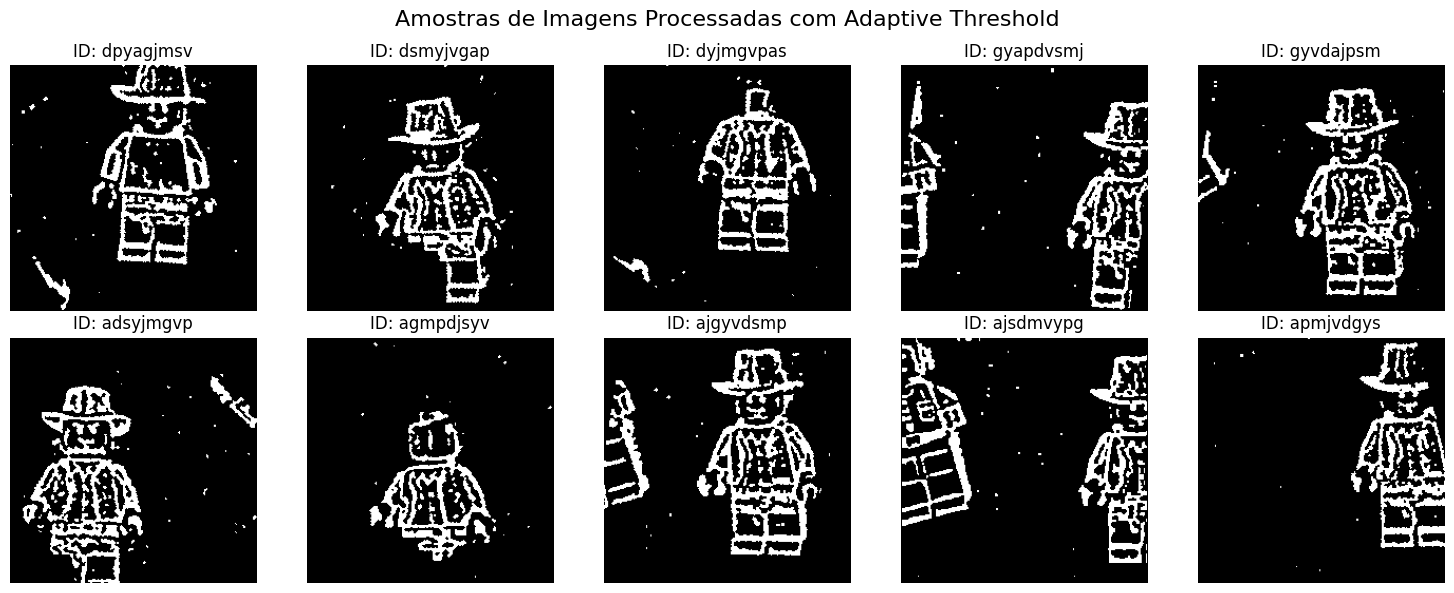

In [17]:
# Visualização de algumas imagens processadas
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Amostras de Imagens Processadas com Adaptive Threshold', fontsize=16)

# Mostrar 5 imagens de teste processadas
for i in range(min(5, len(l2))):
    axes[0, i].imshow(l2[i][0], cmap='gray')
    axes[0, i].set_title(f'ID: {l2[i][1]}')
    axes[0, i].axis('off')

# Mostrar 5 imagens de treino processadas
for i in range(min(5, len(l1))):
    axes[1, i].imshow(l1[i][0], cmap='gray')
    axes[1, i].set_title(f'ID: {l1[i][1]}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

### Funções de Extração das Features

In [18]:
def getStatusLegs(img):
    h, w = img.shape
    i = img[int(0.79*h):h, :]
    soma_colunas = np.sum(i, axis=0)
    colunas_ativas = np.where(soma_colunas > 0)[0]
    if len(colunas_ativas) == 0 or np.ptp(colunas_ativas) < 65:
        return 1
    return 0

def getStatusHat(img):
    h, w = img.shape
    i = img[:int(0.25*h), :]
    soma_colunas = np.sum(i, axis=0)
    colunas_ativas = np.where(soma_colunas > 0)[0]
    if len(colunas_ativas) == 0 or np.ptp(colunas_ativas) < 40:
        return 1
    return 0

def getStatusHead(img):
    if getStatusHat(img) == 0:
        return 0
    h, w = img.shape
    i = img[:int(0.26*h), :]
    a = np.array(i)
    if (np.count_nonzero(a == 255)) < 50:
        return 0
    return 1

def getStatusFace(img):
    if getStatusHead(img) == 1:
        return 1
    h = img.shape[0]
    aux = img[int(0.21*h):int(0.4*h), :]
    if np.all(aux[0, :] != 255) and getStatusHat(img) == 1:
        return 1
    i = -1
    for j, linha in enumerate(img):
        if np.any(linha == 255):
            i = j
            break
    aux = img[i+50:i+61, :]
    if (np.count_nonzero(np.array(aux) == 255)) < 55:
        return 1
    return 0

def getStatusBody(img):
    h, w = img.shape
    i = 10
    for j in range(h - 1, -1, -1):
        linha = img[j, :]
        if np.any(linha == 255):
            i = j
            break
    aux = img[i-115:i-65, (w//2)-25:(w//2)+25]
    if (np.count_nonzero(np.array(aux) == 255)) < 350:
        return 1
    return 0

def getStatusArm(img):
    h, w = img.shape
    i = 10
    for j in range(h - 1, -1, -1):
        linha = img[j, :]
        if np.any(linha == 255):
            i = j
            break
    v = -1
    for j in range(img[i-10:i, :].shape[1] - 1, -1, -1):
        coluna = img[i-10:i, :][:, j]
        if np.any(coluna == 255):
            v = j
            break
    aux = img[i-100:i-55, v:]
    if (np.count_nonzero(np.array(aux) == 255)) == 0:
        return 1
    return 0

def generateFeatures(l2):
    features = []
    l = l2.copy()
    for i, id in l:
        a = np.array(i)
        q = np.count_nonzero(a == 255)
        if q == 0:
            features.append([i, [id, 0, 0, 0, 0, 0, 0, 0, 0]])
        else:
            soma = getStatusLegs(i) + getStatusHat(i) + getStatusHead(i) + getStatusFace(i) + getStatusBody(i) + getStatusArm(i) + getStatusArm(i)
            if soma > 1:
                soma = 1
            features.append([i, [id, soma, getStatusHat(i), getStatusFace(i), getStatusHead(i), getStatusLegs(i), getStatusBody(i), getStatusArm(i), getStatusArm(i)]])
    return sorted(features, key=lambda x: x[1][0])

### Extração das Features

In [19]:
# Extraindo features das imagens de teste
print("Extraindo features...")
features = generateFeatures(l2)
print(f"Features extraídas para {len(features)} imagens")

# Análise estatística das features extraídas
defect_count = sum(1 for f in features if f[1][1] == 1)
no_defect_count = len(features) - defect_count

print(f"\nResultados da análise:")
print(f"Imagens com defeito: {defect_count}")
print(f"Imagens sem defeito: {no_defect_count}")
print(f"Percentual de defeitos: {(defect_count/len(features)*100):.2f}%")

Extraindo features...
Features extraídas para 33 imagens

Resultados da análise:
Imagens com defeito: 19
Imagens sem defeito: 14
Percentual de defeitos: 57.58%


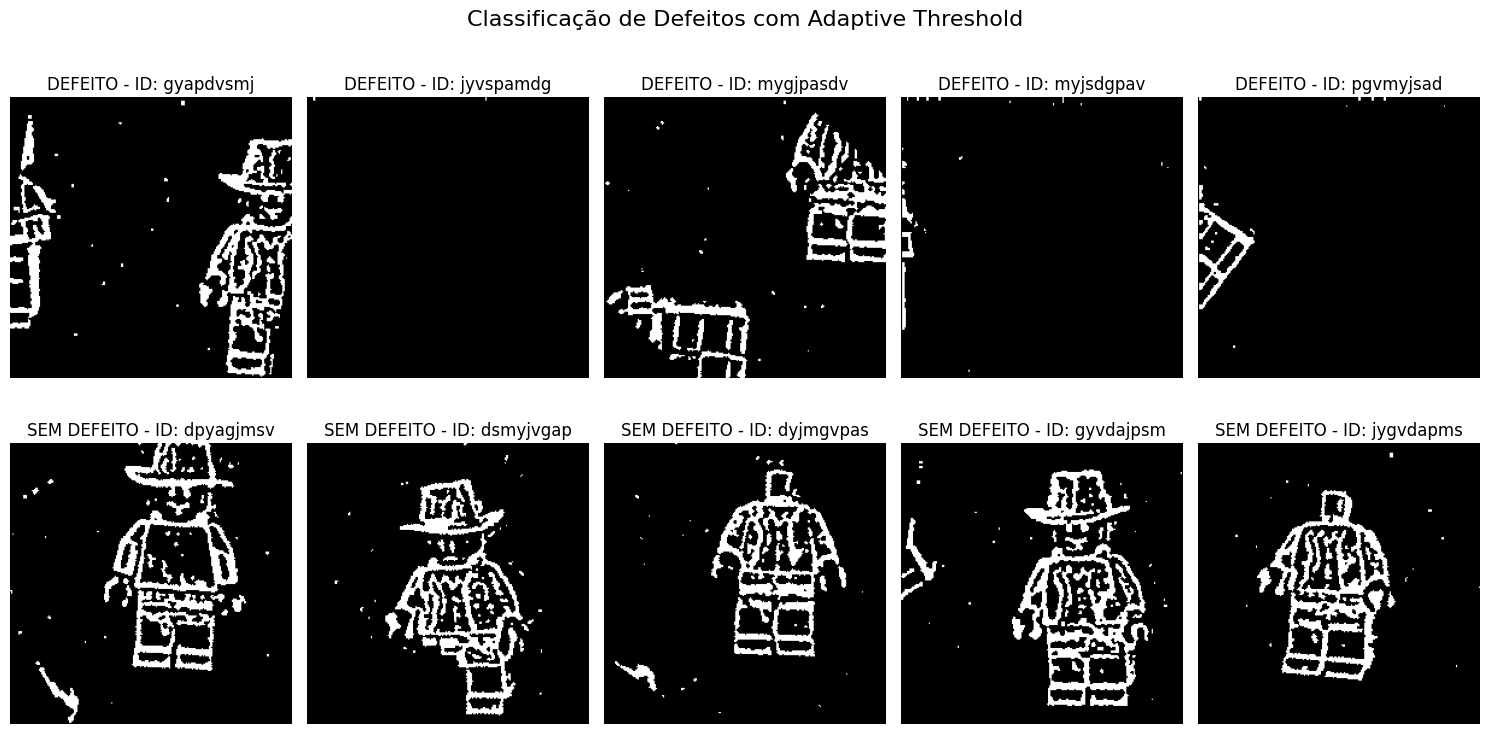

In [20]:
# Visualização de algumas imagens com suas classificações
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
fig.suptitle('Classificação de Defeitos com Adaptive Threshold', fontsize=16)

# Procurar por exemplos com e sem defeitos
defect_examples = [f for f in features if f[1][1] == 1][:5]
no_defect_examples = [f for f in features if f[1][1] == 0][:5]

# Mostrar exemplos com defeito
for i, feature in enumerate(defect_examples):
    if i < 5:
        axes[0, i].imshow(feature[0], cmap='gray')
        axes[0, i].set_title(f'DEFEITO - ID: {feature[1][0]}')
        axes[0, i].axis('off')

# Mostrar exemplos sem defeito
for i, feature in enumerate(no_defect_examples):
    if i < 5:
        axes[1, i].imshow(feature[0], cmap='gray')
        axes[1, i].set_title(f'SEM DEFEITO - ID: {feature[1][0]}')
        axes[1, i].axis('off')

plt.tight_layout()
plt.show()

### Geração de Arquivo CSV

In [21]:
# Preparação dos dados para export
dates = []
for i in features:
    dates.append(i[1])

# Geração do arquivo CSV com timestamp
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"resultados_analise_lego_adaptive_{timestamp}.csv"

header = ["example_id", "has_deffect", "no_hat", "no_face", "no_head", "no_leg", "no_body", "no_hand", "no_arm"]

# Salvar arquivo no diretório lego
output_path = os.path.join(path, filename)
with open(output_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(header)
    for l in dates:
        writer.writerow(l)

print(f"Arquivo salvo em: {output_path}")
print(f"Total de registros: {len(dates)}")

# Também salvar uma cópia como 'send_adaptive.csv' para submission
with open("send_adaptive.csv", 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(header)
    for l in dates:
        writer.writerow(l)
        
print("Arquivo 'send_adaptive.csv' criado para submission")

Arquivo salvo em: C:\Users\mathe\Ufal\PDI\Deffect-detection\lego\resultados_analise_lego_adaptive_20250531_031506.csv
Total de registros: 33
Arquivo 'send_adaptive.csv' criado para submission


### Comparação: Adaptive Threshold vs Canny

Este notebook substitui o detector de bordas **Canny** pelo **Adaptive Threshold** com as seguintes vantagens:

1. **Robustez à Iluminação**: O adaptive threshold se adapta automaticamente às variações de iluminação na imagem
2. **Melhor Preservação de Detalhes**: Mantém mais informações sobre a estrutura das peças LEGO
3. **Menos Sensível a Ruído**: O filtro Gaussiano aplicado antes do threshold reduz o impacto do ruído
4. **Parâmetros Ajustáveis**: Os parâmetros `blockSize` e `C` podem ser finemente ajustados para diferentes tipos de defeitos

**Parâmetros utilizados:**
- `blockSize=11`: Tamanho da janela para calcular o threshold adaptativo
- `C=2`: Constante subtraída da média ponderada
- `alpha=1.2, beta=-50`: Ajuste de contraste e brilho
- Filtro Gaussiano `(5,5)`: Redução de ruído antes do threshold